<style>
@font-face {
  font-family: 'IRANSans';
  src: url('fonts/IRANSansXFaNum-Regular.ttf') format('woff');
}
.custom-font {
  font-family: 'IRANSans';
  direction: rtl;
}
</style>

<h1 align=center style="line-height:200%;font-family:IRANSans;color:#0099cc">
<font face="IRANSans" color="#0099cc">
مسئله‌ی ۲: پیش‌بینی
</font>
</h1>

<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
بارگذاری داده و آماده‌سازی اولیه
</font>
</h2>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb  
import matplotlib.font_manager as fm
import arabic_reshaper
from bidi.algorithm import get_display
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
font_path = "fonts/IRANSansXFaNum-Regular.ttf" 
font_prop = fm.FontProperties(fname=font_path)

In [3]:
df = pd.read_csv('Divar.csv')

<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
      پیش‌ پردازش داده‌ها
</font>
</h2>


In [4]:
       
df_filtered = df[df['price_value'].notna()].copy()
print(f"تعداد رکوردهای فروشی: {len(df_filtered):,}")
        
# حذف outlierهای شدید در قیمت
Q1 = df_filtered['price_value'].quantile(0.01)
Q3 = df_filtered['price_value'].quantile(0.99)
df_filtered = df_filtered[(df_filtered['price_value'] >= Q1) & (df_filtered['price_value'] <= Q3)]
print(f"پس از حذف outlierها: {len(df_filtered):,}")

تعداد رکوردهای فروشی: 568,346
پس از حذف outlierها: 557,001


<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
      مهندسی ویژگی‌ها
</font>
</h2>


In [5]:
df_features = df_filtered.copy()

# تبدیل اعداد فارسی به انگلیسی
def convert_persian_year_to_numeric(year_str):
        if pd.isna(year_str):
            return np.nan
        try:
            persian_to_english = {'۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
                                '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'}
            english_year = str(year_str)
            for p, e in persian_to_english.items():
                english_year = english_year.replace(p, e)
            return int(english_year)
        except:
            return np.nan


# تبدیل سال ساخت فارسی به میلادی
if 'construction_year' in df_features.columns:
    df_features['construction_year_numeric'] = df_features['construction_year'].apply(
        convert_persian_year_to_numeric
    )
    # محاسبه سن ساختمان
    current_year = 1404  # سال جاری شمسی
    df_features['building_age'] = current_year - df_features['construction_year_numeric']
    df_features['building_age'] = df_features['building_age'].clip(0, 100)
        
# تبدیل تعداد اتاق‌ها به عدد
if 'rooms_count' in df_features.columns:
    room_mapping = {
        'بدون اتاق': 0, 'یک': 1, 'دو': 2, 'سه': 3, 
        'چهار': 4, 'پنج': 5, 'شش': 6
    }
    df_features['rooms_numeric'] = df_features['rooms_count'].map(room_mapping)
        
# تبدیل طبقه به عدد
if 'floor' in df_features.columns:
    df_features['floor_numeric'] = pd.to_numeric(df_features['floor'], errors='coerce')
        
# تبدیل تعداد کل طبقات به عدد
if 'total_floors_count' in df_features.columns:
    df_features['total_floors_numeric'] = pd.to_numeric(df_features['total_floors_count'], errors='coerce')
        
# تبدیل تعداد واحد در طبقه به عدد
if 'unit_per_floor' in df_features.columns:
    df_features['unit_per_floor_numeric'] = pd.to_numeric(df_features['unit_per_floor'], errors='coerce')
        
# محاسبه قیمت هر متر
if 'building_size' in df_features.columns:
    df_features['price_per_sqm'] = df_features['price_value'] / df_features['building_size']
    df_features['price_per_sqm'] = df_features['price_per_sqm'].replace([np.inf, -np.inf], np.nan)
        
# ویژگی‌های ترکیبی
if all(col in df_features.columns for col in ['building_size', 'land_size']):
    df_features['building_to_land_ratio'] = df_features['building_size'] / df_features['land_size']
    df_features['building_to_land_ratio'] = df_features['building_to_land_ratio'].replace([np.inf, -np.inf], np.nan)
        
# امتیاز امکانات
amenity_cols = ['has_balcony', 'has_elevator', 'has_warehouse', 'has_parking']
for col in amenity_cols:
    if col in df_features.columns:
        df_features[col] = df_features[col].map({'true': 1, True: 1, 'false': 0, False: 0})
        
if all(col in df_features.columns for col in amenity_cols):
    df_features['amenity_score'] = df_features[amenity_cols].sum(axis=1)

<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
      انتخاب ویژگی‌ها
</font>
</h2>


In [6]:
# ویژگی‌های عددی مهم
numeric_features = [
    'building_size', 'land_size', 'location_latitude', 'location_longitude',
    'building_age', 'rooms_numeric', 'floor_numeric', 'total_floors_numeric',
    'unit_per_floor_numeric', 'amenity_score', 'building_to_land_ratio'
]
        
# ویژگی‌های کاتگوریکال مهم
categorical_features = [
    'cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug',
    'deed_type', 'building_direction', 'floor_material',
    'has_warm_water_provider', 'has_heating_system', 'has_cooling_system'
]
        
# فیلتر کردن ویژگی‌هایی که در دیتا موجودند
available_numeric = [col for col in numeric_features if col in df.columns]
available_categorical = [col for col in categorical_features if col in df.columns]
        
print(f"ویژگی‌های عددی: {len(available_numeric)}")
print(f"ویژگی‌های کاتگوریکال: {len(available_categorical)}")

ویژگی‌های عددی: 4
ویژگی‌های کاتگوریکال: 10


<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
      آماده‌سازی داده‌ها
</font>
</h2>


In [7]:
df_model = df_features.copy()
label_encoders = {}

# پر کردن مقادیر missing برای ویژگی‌های عددی
numeric_imputer = SimpleImputer(strategy='median')
for col in numeric_features:
    if col in df_model.columns:
        df_model[col] = numeric_imputer.fit_transform(df_model[[col]]).flatten()
        
# پر کردن مقادیر missing برای ویژگی‌های کاتگوریکال
categorical_imputer = SimpleImputer(strategy='most_frequent')
for col in categorical_features:
    if col in df_model.columns:
        df_model[col] = categorical_imputer.fit_transform(df_model[[col]]).flatten()

# Label Encoding برای ویژگی‌های کاتگوریکال
for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        
# انتخاب ویژگی‌های نهایی
final_features = numeric_features + [col + '_encoded' for col in categorical_features if col in df_model.columns]
final_features = [col for col in final_features if col in df_model.columns]
        
# آماده‌سازی X و y
X = df_model[final_features]
y = df_model['price_value']
        
# حذف رکوردهایی که هنوز NaN دارند
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
        
print(f"شکل نهایی داده‌ها: {X.shape}")
print(f"تعداد ویژگی‌ها: {len(final_features)}")

شکل نهایی داده‌ها: (557001, 21)
تعداد ویژگی‌ها: 21


<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
      آموزش مدل‌های پایه
</font>
</h2>


In [17]:
scaler = StandardScaler()
models = {}
# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
# نرمال‌سازی داده‌ها
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        
# تعریف مدل‌ها - XGBoost اضافه شده
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1000),
    'Lasso Regression': Lasso(alpha=1000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(  # مدل جدید XGBoost
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0  # برای کم کردن پیام‌های اضافی
    )
}
        
results = {}
        
for name, model in models.items():
    print(f" آموزش {name}...")
            
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
            
    # محاسبه معیارهای ارزیابی
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
            
    results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred,
        'y_test': y_test
    }

    print(f"{name}: R² = {r2:.3f}, MAE = {mae:,.0f}, RMSE = {rmse:,.0f}, MSE = {mse:,.0f}")

models = results    
        

 آموزش Linear Regression...
Linear Regression: R² = 0.204, MAE = 3,893,636,269, RMSE = 7,297,929,355, MSE = 53,259,772,870,673,375,232
 آموزش Ridge Regression...
Ridge Regression: R² = 0.204, MAE = 3,892,119,696, RMSE = 7,297,910,634, MSE = 53,259,499,626,522,353,664
 آموزش Lasso Regression...
Lasso Regression: R² = 0.204, MAE = 3,893,635,656, RMSE = 7,297,929,344, MSE = 53,259,772,712,723,906,560
 آموزش Random Forest...
Random Forest: R² = 0.619, MAE = 2,110,391,456, RMSE = 5,049,381,208, MSE = 25,496,250,579,224,698,880
 آموزش Gradient Boosting...
Gradient Boosting: R² = 0.489, MAE = 2,777,960,730, RMSE = 5,848,251,697, MSE = 34,202,047,917,171,957,760
 آموزش XGBoost...
XGBoost: R² = 0.573, MAE = 2,449,367,418, RMSE = 5,345,267,957, MSE = 28,571,889,537,081,970,688


<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
     ارزیابی مدل‌ها
</font>
</h2>


In [18]:
comparison_df = pd.DataFrame({
    'مدل': list(models.keys()),
    'R² Score': [models[name]['r2'] for name in models.keys()],
    'MAE (میلیون تومان)': [models[name]['mae']/1000000 for name in models.keys()],
    'RMSE (میلیون تومان)': [models[name]['rmse']/1000000 for name in models.keys()],
    'MSE (میلیون تومان)': [models[name]['mse']/1000000 for name in models.keys()]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print(comparison_df.to_string(index=False, float_format='%.3f'))

# بهترین مدل
best_model_name = comparison_df.iloc[0]['مدل']
print(f"\nبهترین مدل: {best_model_name}")

              مدل  R² Score  MAE (میلیون تومان)  RMSE (میلیون تومان)  MSE (میلیون تومان)
    Random Forest     0.619            2110.391             5049.381  25496250579224.699
          XGBoost     0.573            2449.367             5345.268  28571889537081.969
Gradient Boosting     0.489            2777.961             5848.252  34202047917171.957
 Ridge Regression     0.204            3892.120             7297.911  53259499626522.352
 Lasso Regression     0.204            3893.636             7297.929  53259772712723.906
Linear Regression     0.204            3893.636             7297.929  53259772870673.375

بهترین مدل: Random Forest


<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
     نمایش نتایج
</font>
</h2>


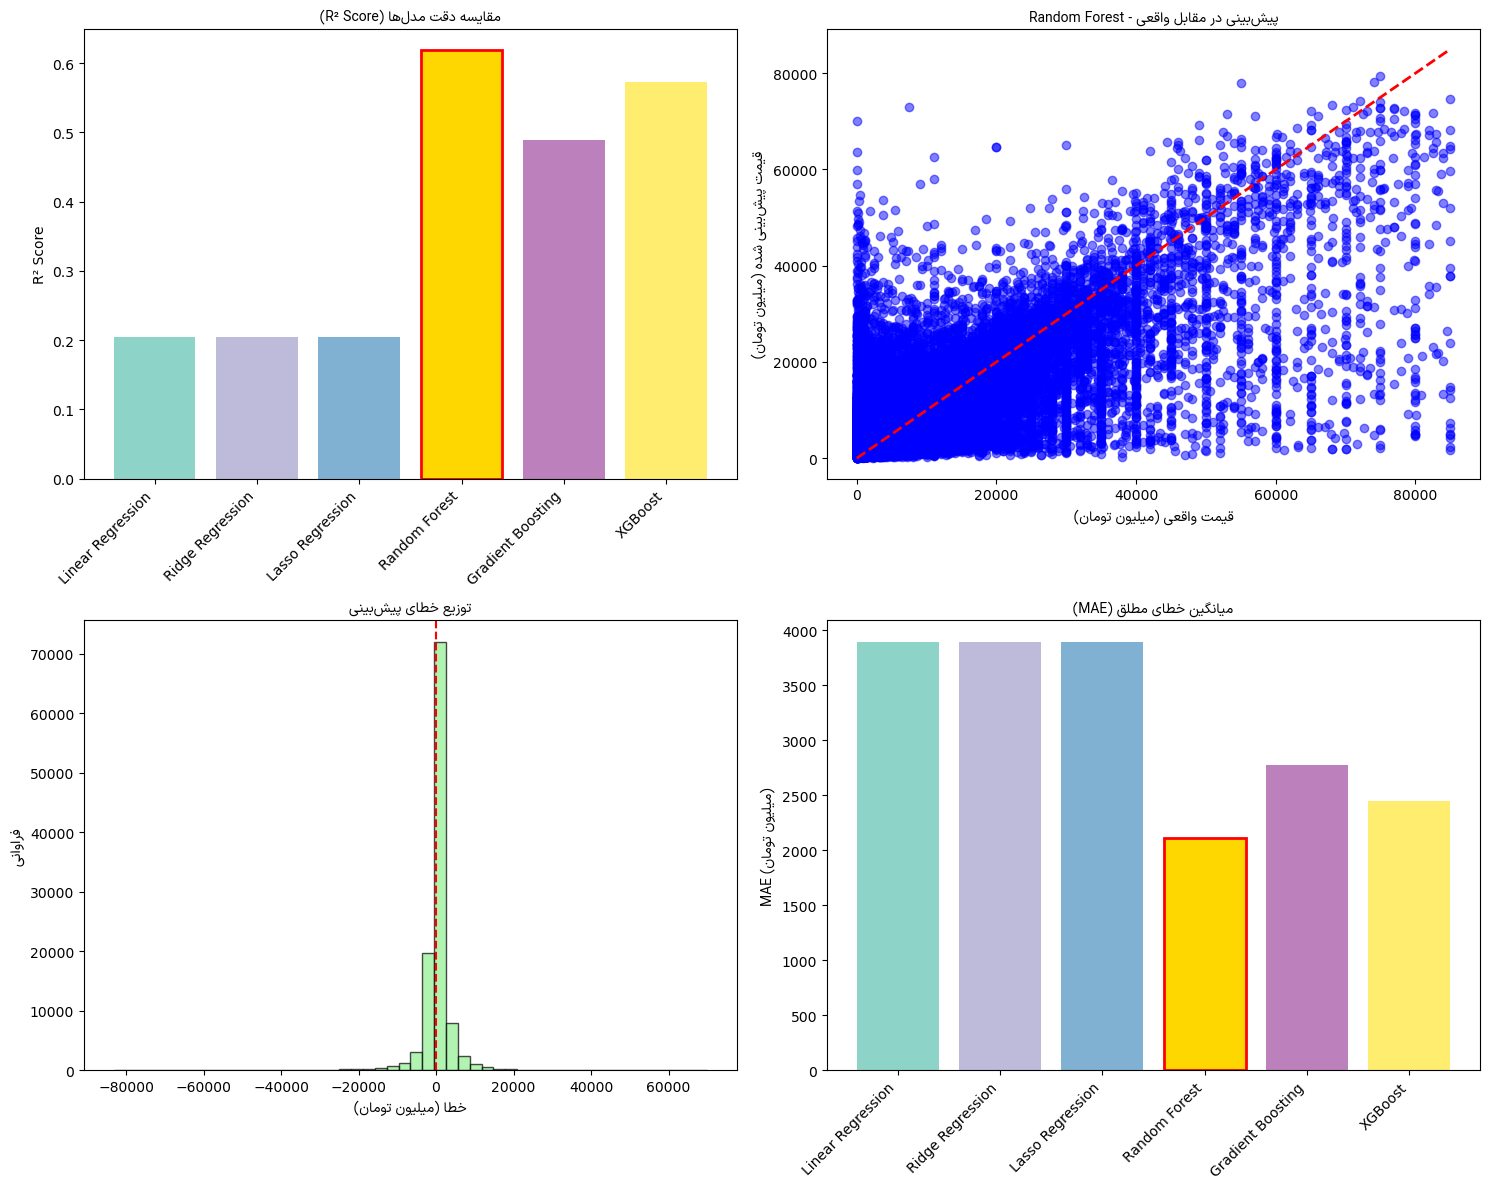

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
# 1. مقایسه مدل‌ها
model_names = list(models.keys())
r2_scores = [models[name]['r2'] for name in model_names]
        
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = axes[0,0].bar(range(len(model_names)), r2_scores, color=colors)
axes[0,0].set_xticks(range(len(model_names)))
axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0,0].set_title(get_display(arabic_reshaper.reshape("مقایسه دقت مدل‌ها (R² Score)")), fontproperties=font_prop)
axes[0,0].set_ylabel('R² Score')
        
# هایلایت کردن بهترین مدل
best_idx = model_names.index(best_model_name)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)
        
# 2. پیش‌بینی در مقابل واقعی (بهترین مدل)
best_model = models[best_model_name]
y_test = best_model['y_test']
y_pred = best_model['y_pred']
        
axes[0,1].scatter(y_test/1000000, y_pred/1000000, alpha=0.5, color='blue')
min_val = min(y_test.min(), y_pred.min())/1000000
max_val = max(y_test.max(), y_pred.max())/1000000
axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0,1].set_xlabel(get_display(arabic_reshaper.reshape("قیمت واقعی (میلیون تومان)")), fontproperties=font_prop)
axes[0,1].set_ylabel(get_display(arabic_reshaper.reshape("قیمت پیش‌بینی شده (میلیون تومان)")), fontproperties=font_prop)
axes[0,1].set_title(get_display(arabic_reshaper.reshape(f'پیش‌بینی در مقابل واقعی - {best_model_name}')), fontproperties=font_prop)
        
        # 3. توزیع خطا
errors = (y_pred - y_test) / 1000000
axes[1,0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1,0].set_xlabel(get_display(arabic_reshaper.reshape("خطا (میلیون تومان)")), fontproperties=font_prop)
axes[1,0].set_ylabel(get_display(arabic_reshaper.reshape("فراوانی")), fontproperties=font_prop)
axes[1,0].set_title(get_display(arabic_reshaper.reshape("توزیع خطای پیش‌بینی")), fontproperties=font_prop)
axes[1,0].axvline(0, color='red', linestyle='--')
        
# 4. MAE مدل‌ها
mae_scores = [models[name]['mae']/1000000 for name in model_names]
bars_mae = axes[1,1].bar(range(len(model_names)), mae_scores, color=colors)
axes[1,1].set_xticks(range(len(model_names)))
axes[1,1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1,1].set_title(get_display(arabic_reshaper.reshape("میانگین خطای مطلق (MAE)")), fontproperties=font_prop)
axes[1,1].set_ylabel(get_display(arabic_reshaper.reshape("MAE (میلیون تومان)")), fontproperties=font_prop)
        
# هایلایت کردن بهترین مدل در MAE
best_mae_idx = np.argmin(mae_scores)
bars_mae[best_mae_idx].set_color('gold')
bars_mae[best_mae_idx].set_edgecolor('red')
bars_mae[best_mae_idx].set_linewidth(2)
        
plt.tight_layout()
plt.show()

<h2 dir=rtl align=right style="line-height:200%;font-family:IRANSans;color:#0099cc; padding-right:10px">
<font face="IRANSans" color="#0099cc">
     تحلیل اهمیت ویژگی‌ها
</font>
</h2>



اهمیت ویژگی‌ها در مدل Random Forest:
--------------------------------------------------
                     ویژگی  اهمیت
             building_size 0.2358
         city_slug_encoded 0.2086
             rooms_numeric 0.1028
         location_latitude 0.0973
        location_longitude 0.0837
 neighborhood_slug_encoded 0.0714
              building_age 0.0466
         cat3_slug_encoded 0.0325
                 land_size 0.0236
             amenity_score 0.0209
    building_to_land_ratio 0.0204
             floor_numeric 0.0135
         cat2_slug_encoded 0.0075
has_heating_system_encoded 0.0061
    floor_material_encoded 0.0054


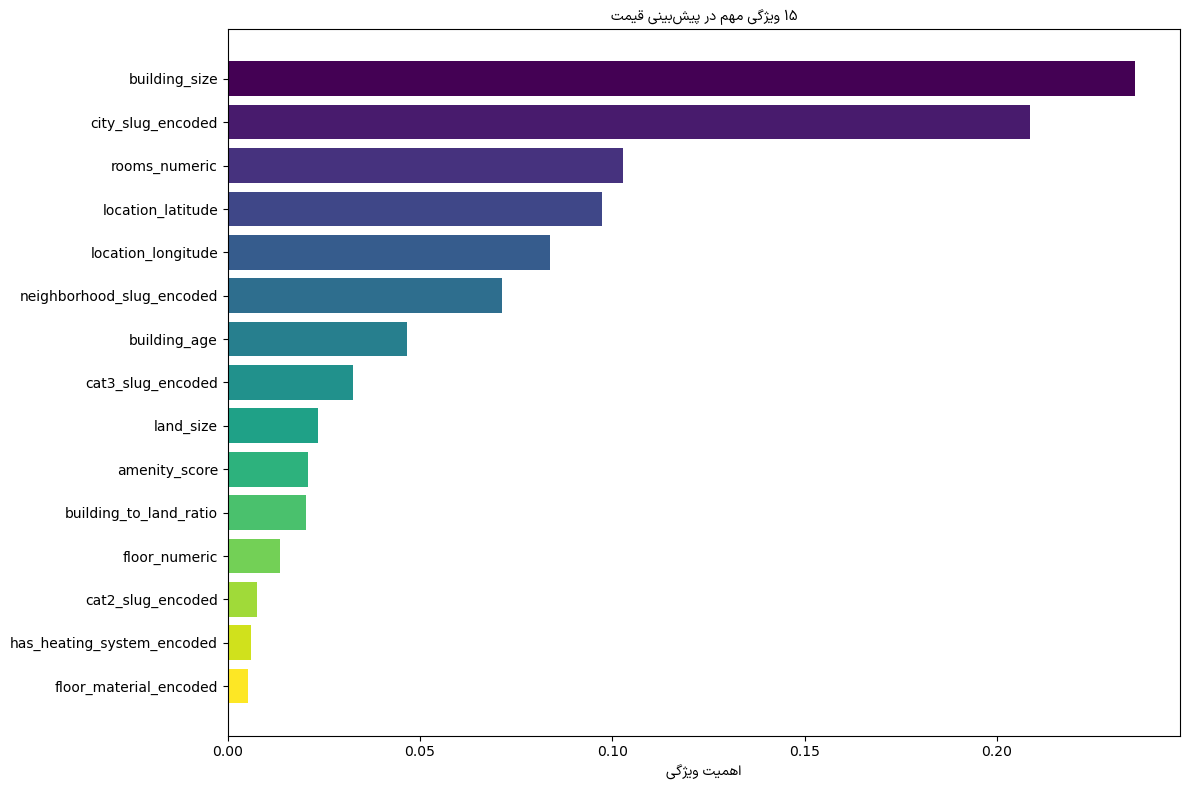

In [22]:
model = models[best_model_name]['model']
            
importance_df = pd.DataFrame({
    'ویژگی': final_features,
    'اهمیت': model.feature_importances_
}).sort_values('اهمیت', ascending=False)
            
print(f"\nاهمیت ویژگی‌ها در مدل {best_model_name}:")
print("-" * 50)
print(importance_df.head(15).to_string(index=False, float_format='%.4f'))
            
# نمودار اهمیت ویژگی‌ها
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['اهمیت'], color=colors)
plt.yticks(range(len(top_features)), top_features['ویژگی'])
plt.xlabel(get_display(arabic_reshaper.reshape("اهمیت ویژگی")), fontproperties=font_prop)
plt.title(get_display(arabic_reshaper.reshape("15 ویژگی مهم در پیش‌بینی قیمت")), fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()